# Weisfeiler-Lehman Neural Machine for Link Prediction

## Importing the library

In [1]:
import networkx as nx
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import math
import pandas as pd

## Importing the dataset

In [2]:
data = scipy.io.loadmat('data/USAir.mat')

In [3]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Oct 20 12:21:53 2016',
 '__version__': '1.0',
 '__globals__': [],
 'net': <332x332 sparse matrix of type '<class 'numpy.float64'>'
 	with 4252 stored elements in Compressed Sparse Column format>}

## Create a graph from the adjacency matrix

In [4]:
network = nx.from_numpy_matrix(data['net'].todense())

In [5]:
network.number_of_nodes(), network.number_of_edges()

(332, 2126)

## Dividing the network into the training and test networks

In [6]:
network_train = network.copy()
network_test = nx.empty_graph(network_train.number_of_nodes())

In [7]:
test_ratio = 0.1
n_links = network_train.number_of_edges()
n_links_test = math.ceil(test_ratio * n_links)

In [8]:
n_links_test

213

In [9]:
selected_links_id = np.random.choice(np.arange(n_links), size=n_links_test, replace=False)

In [10]:
network_adj_matrix = nx.adj_matrix(network)
network_adj_matrix = scipy.sparse.triu(network_adj_matrix, k=1)
row_index, col_index = network_adj_matrix.nonzero()
links = [(x, y) for x, y in zip(row_index, col_index)]

In [11]:
selected_links = []
for link_id in selected_links_id:
    selected_links.append(links[link_id])
network_train.remove_edges_from(selected_links)
network_test.add_edges_from(selected_links)

In [12]:
network_train.number_of_edges(), network_test.number_of_edges()

(1913, 213)

## Sampling negative links

In [13]:
k = 2
n_links_train_pos = network_train.number_of_edges()
n_links_test_pos = network_test.number_of_edges()
n_links_train_neg = k * n_links_train_pos
n_links_test_neg = k * n_links_test_pos

In [14]:
neg_network = nx.empty_graph(network.number_of_nodes())
links_neg = list(nx.non_edges(network))
neg_network.add_edges_from(links_neg)

In [15]:
n_links_neg = neg_network.number_of_edges()
n_links_neg

52820

In [16]:
selected_links_neg_id = np.random.choice(np.arange(n_links_neg), size=n_links_train_neg + n_links_test_neg, replace=False)

In [17]:
neg_network_train = nx.empty_graph(network.number_of_nodes())
neg_network_test = nx.empty_graph(network.number_of_nodes())

In [18]:
selected_links = []
for i in range(n_links_train_neg):
    link_id = selected_links_neg_id[i]
    selected_links.append(links_neg[link_id])
neg_network_train.add_edges_from(selected_links)

selected_links = []
for i in range(n_links_train_neg, n_links_train_neg + n_links_test_neg):
    link_id = selected_links_neg_id[i]
    selected_links.append(links_neg[link_id])
neg_network_test.add_edges_from(selected_links)

In [19]:
neg_network_train.number_of_nodes(), neg_network_test.number_of_nodes()

(332, 332)

In [20]:
neg_network_train.number_of_edges(), neg_network_test.number_of_edges()

(3826, 426)

## Grouping training and test links

In [21]:
all_links_train = list(network_train.edges) + list(neg_network_train.edges)
label_train = [1] * len(network_train.edges) + [0] * len(neg_network_train.edges)

In [22]:
all_links_test = list(network_test.edges) + list(neg_network_test.edges)
label_test = [1] * len(network_test.edges) + [0] * len(neg_network_test.edges)

In [23]:
y_train, y_test = np.array(label_train), np.array(label_test)

## Extracting enclosing subgraph for each links

In [25]:
link = all_links_train[12]
link

(5, 12)

In [26]:
fringe = [link]
subgraph = nx.Graph()

In [27]:
def enclosing_subgraph(fringe, network, subgraph, distance):
    neighbor_links = []
    for link in fringe:
        u = link[0]
        v = link[1]
        neighbor_links = neighbor_links + list(network.edges(u))
        neighbor_links = neighbor_links + list(network.edges(v))
    tmp_subgraph = subgraph.copy()
    tmp_subgraph.add_edges_from(neighbor_links)
    # Remove duplicate and existed edge
    neighbor_links = [li for li in tmp_subgraph.edges() if li not in subgraph.edges()]
    tmp_subgraph = subgraph.copy()
    tmp_subgraph.add_edges_from(neighbor_links, distance=distance, inverse_distance=1/distance)
    return neighbor_links, tmp_subgraph

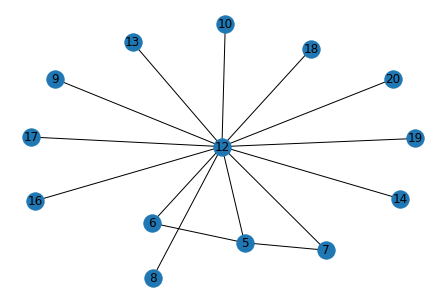

In [28]:
fringe, subgraph = enclosing_subgraph(fringe, network_train, subgraph, distance=1)
nx.draw(subgraph, with_labels=True);

In [29]:
def extract_enclosing_subgraph(link, network, size=10):
    fringe = [link]
    subgraph = nx.Graph()
    distance = 0
    subgraph.add_edge(link[0], link[1], distance=distance)
    while subgraph.number_of_nodes() < size and len(fringe) > 0:
        distance += 1
        fringe, subgraph = enclosing_subgraph(fringe, network, subgraph, distance)
    
    tmp_subgraph = network.subgraph(subgraph.nodes)
    additional_edges = [li for li in tmp_subgraph.edges if li not in subgraph.edges]
    subgraph.add_edges_from(additional_edges, distance=distance+1, inverse_distance=1/(distance+1))
    return subgraph

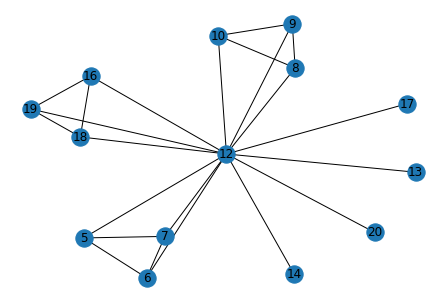

In [30]:
e_subgraph = extract_enclosing_subgraph(link, network_train)
nx.draw(e_subgraph, with_labels=True)

In [31]:
e_subgraph[6]

AtlasView({5: {'distance': 1, 'inverse_distance': 1.0}, 12: {'distance': 1, 'inverse_distance': 1.0}, 7: {'distance': 2, 'inverse_distance': 0.5}})

In [31]:
%%timeit
extract_enclosing_subgraph(link, network_train)

227 µs ± 3.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
%%timeit
for link in all_links_train:
    e_subgraph = extract_enclosing_subgraph(link, network_train)

15.7 s ± 97.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Subgraph encoding
### Palette-WL for vertex ordering

In [32]:
def compute_geometric_mean_distance(subgraph, link):
    u = link[0]
    v = link[1]
    subgraph.remove_edge(u, v)
    
    n_nodes = subgraph.number_of_nodes()
    u_reachable = nx.descendants(subgraph, source=u)
    v_reachable = nx.descendants(subgraph, source=v)
#     print(u_reachable, v_reachable)
    for node in subgraph.nodes:
        distance_to_u = 0
        distance_to_v = 0
        if node != u:
            distance_to_u = nx.shortest_path_length(subgraph, source=node, target=u) if node in u_reachable else 2 ** n_nodes
        if node != v:
            distance_to_v = nx.shortest_path_length(subgraph, source=node, target=v) if node in v_reachable else 2 ** n_nodes
        subgraph.nodes[node]['avg_dist'] = math.sqrt(distance_to_u * distance_to_v)
    
    subgraph.add_edge(u, v, distance=0)
    
    return subgraph

In [33]:
e_subgraph = compute_geometric_mean_distance(e_subgraph, link)

In [34]:
avg_dist = nx.get_node_attributes(e_subgraph, 'avg_dist')
avg_dist

{5: 0.0,
 12: 0.0,
 6: 1.0,
 7: 1.0,
 8: 1.7320508075688772,
 9: 1.7320508075688772,
 10: 1.7320508075688772,
 13: 1.7320508075688772,
 14: 1.7320508075688772,
 16: 1.7320508075688772,
 17: 1.7320508075688772,
 18: 1.7320508075688772,
 19: 1.7320508075688772,
 20: 1.7320508075688772}

In [35]:
def prime(x):
    if x < 2:
        return False
    if x == 2 or x == 3:
        return True
    for i in range(2, x):
        if x % i == 0:
            return False
    return True

In [36]:
prime_numbers = np.array([i for i in range (10000) if prime(i)], dtype=np.int)

In [37]:
prime_numbers.shape

(1229,)

In [38]:
def palette_wl(subgraph, link):
    tmp_subgraph = subgraph.copy()
    if tmp_subgraph.has_edge(link[0], link[1]):
        tmp_subgraph.remove_edge(link[0], link[1])
    avg_dist = nx.get_node_attributes(tmp_subgraph, 'avg_dist')
    
    df = pd.DataFrame.from_dict(avg_dist, orient='index', columns=['hash_value'])
    df = df.sort_index()
    df['order'] = df['hash_value'].rank(axis=0, method='min').astype(np.int)
    df['previous_order'] = np.zeros(df.shape[0], dtype=np.int)
    adj_matrix = nx.adj_matrix(tmp_subgraph, nodelist=sorted(tmp_subgraph.nodes)).todense()
    while any(df.order != df.previous_order):
        df['log_prime'] = np.log(prime_numbers[df['order'].values])
        total_log_primes = np.ceil(np.sum(df.log_prime.values))
        df['hash_value'] = adj_matrix * df.log_prime.values.reshape(-1, 1) / total_log_primes + df.order.values.reshape(-1, 1)
        df.previous_order = df.order
        df.order = df.hash_value.rank(axis=0, method='min').astype(np.int)
    nodelist = df.order.sort_values().index.values
    return nodelist

In [39]:
nodelist = palette_wl(e_subgraph, link)
nodelist

array([ 5, 12,  6,  7, 13, 14, 17, 20,  8,  9, 10, 16, 18, 19])

In [40]:
size = 10
if len(nodelist) > size:
    nodelist = nodelist[:size]
    e_subgraph = e_subgraph.subgraph(nodelist)
    nodelist = palette_wl(e_subgraph, link)

In [41]:
nodelist

array([ 5, 12,  6,  7, 13, 14, 17, 20,  8,  9])

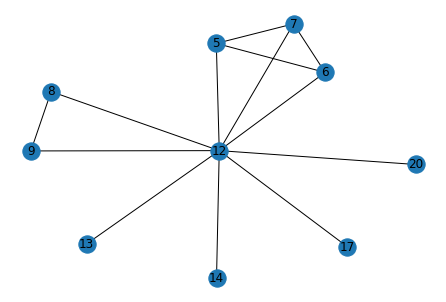

In [42]:
nx.draw(e_subgraph, with_labels=True);

In [43]:
e_subgraph.nodes[7]

{'avg_dist': 1.0}

### Represent enclosing subgraphs as adjacency matrices

In [44]:
def sample(subgraph, nodelist, weight='weight', size=10):
    adj_matrix = nx.adj_matrix(subgraph, weight=weight, nodelist=nodelist).todense()
    vector = np.asarray(adj_matrix)[np.triu_indices(len(adj_matrix), k=1)]
    d = size * (size - 1) // 2
    if len(vector) < d:
        vector = np.append(vector, np.zeros(d - len(vector)))
    return vector[1:]

In [45]:
sample(e_subgraph, nodelist, size=10)

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

### Subgraph encoding test

In [46]:
link

(5, 12)

In [47]:
e_subgraph = extract_enclosing_subgraph(link, network_train, size=10)
e_subgraph = compute_geometric_mean_distance(e_subgraph, link)
nodelist = palette_wl(e_subgraph, link)
if len(nodelist) > size:
    nodelist = nodelist[:size]
    e_subgraph = e_subgraph.subgraph(nodelist)
    nodelist = palette_wl(e_subgraph, link)
embeded = sample(e_subgraph, nodelist, size=10)

In [48]:
embeded

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

## Enclosing subgraph encoding for each links

In [49]:
def encode_link(link, network, weight='weight', size=10):
    e_subgraph = extract_enclosing_subgraph(link, network, size=size)
    e_subgraph = compute_geometric_mean_distance(e_subgraph, link)
    nodelist = palette_wl(e_subgraph, link)
    if len(nodelist) > size:
        nodelist = nodelist[:size]
        e_subgraph = e_subgraph.subgraph(nodelist)
        nodelist = palette_wl(e_subgraph, link)
    embeded_link = sample(e_subgraph, nodelist, weight=weight, size=size)
    return embeded_link

In [50]:
from functools import partial

In [52]:
%%timeit
np.array(list(map(partial(encode_link, network=network_train, weight='inverse_distance', size=10), all_links_train)))

1min 55s ± 681 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
X_train = np.array(list(map(partial(encode_link, network=network_train, weight='weight', size=10), all_links_train)))

In [74]:
X_train.shape

(5739, 44)

In [75]:
X_test = np.array(list(map(partial(encode_link, network=network_train, weight='weight', size=10), all_links_test)))

In [76]:
from sklearn.utils import shuffle
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [77]:
X_train_shuffle.shape, y_train.shape

((5739, 44), (5739,))

## Neural Network Learning

In [78]:
from sklearn.neural_network import MLPClassifier

In [79]:
model = MLPClassifier(hidden_layer_sizes=(32, 32, 16),
                      alpha=1e-3,
                      batch_size=128,
                      learning_rate_init=0.001,
                      max_iter=100,
                      verbose=True,
                      early_stopping=False,
                      tol=-10000)

In [80]:
model.fit(X_train_shuffle, y_train_shuffle)

Iteration 1, loss = 0.60553938
Iteration 2, loss = 0.36856008
Iteration 3, loss = 0.29921278
Iteration 4, loss = 0.27557887
Iteration 5, loss = 0.26432179
Iteration 6, loss = 0.25284156
Iteration 7, loss = 0.24676931
Iteration 8, loss = 0.23968218
Iteration 9, loss = 0.23594479
Iteration 10, loss = 0.23085988
Iteration 11, loss = 0.22782874
Iteration 12, loss = 0.22406891
Iteration 13, loss = 0.22050878
Iteration 14, loss = 0.21808646
Iteration 15, loss = 0.22032729
Iteration 16, loss = 0.21285005
Iteration 17, loss = 0.21162807
Iteration 18, loss = 0.20600683
Iteration 19, loss = 0.20273449
Iteration 20, loss = 0.20223407
Iteration 21, loss = 0.20006986
Iteration 22, loss = 0.19742621
Iteration 23, loss = 0.19942512
Iteration 24, loss = 0.19452788
Iteration 25, loss = 0.19523408
Iteration 26, loss = 0.19511215
Iteration 27, loss = 0.19040171
Iteration 28, loss = 0.18989748
Iteration 29, loss = 0.18629454
Iteration 30, loss = 0.18410081
Iteration 31, loss = 0.18312447
Iteration 32, los

/home/kienmn/Workspace/JupyterWorkspace/jupyter_env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.001, batch_size=128, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 32, 16), learning_rate='constant',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=-10000,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [81]:
predictions = model.predict(X_test)

In [82]:
from sklearn import metrics

In [83]:
fpr, tpr, thresholds = metrics.roc_curve(label_test, predictions, pos_label=1)
auc = metrics.auc(fpr, tpr)
print(auc)

0.8838028169014084
